In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, plot_roc_curve

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import bisect
import os
import json

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))

train = pd.read_csv(os.path.join(BASE_DIR, "data/train_Df64byy.csv"))
test = pd.read_csv(os.path.join(BASE_DIR, "data/test_YCcRUnU.csv"))

print(f"Train Shape: {train.shape}")
print(f"\nTrain information: {train.info()}\n")
print(f"Test Shape: {test.shape}")
print(f"\nTest information: {test.info()}")

def get_data_types_df(df):
    grouped_data_type_cols = df.columns.to_series().groupby(df.dtypes).groups
    grouped_data_type_cols = {k.name: v for k, v in grouped_data_type_cols.items()}
    max_attrs = max([len(list(x)) for x in list(grouped_data_type_cols.values())])
    columns = [f"attr_{x+1}" for x in range(max_attrs)]
    attributes_by_datatype = pd.DataFrame(list(grouped_data_type_cols.values()),
                                          index=grouped_data_type_cols.keys(),
                                          columns=columns)

    return attributes_by_datatype

get_data_types_df(train)

Train Shape: (50882, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dt

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6
int64,ID,Region_Code,Upper_Age,Lower_Age,Reco_Policy_Cat,Response
float64,Holding_Policy_Type,Reco_Policy_Premium,None,None,None,None
object,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health Indicator,Holding_Policy_Duration


In [3]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [4]:
"""
# After checking the data types, we notice that 
# Region_Code, Reco_Policy_Cat, Response, 
# Holding_Policy_Type is an integer. Should be categorical
"""
def numerical_to_categorical(df, cols):
    for col in cols:
        df[col] = df[col].astype(str)

    return df

def drop_unwanted_cols(df, cols):
    
    unwanted_cols = []
    for col in cols:
        if col in df.columns.tolist():
            unwanted_cols.append(col)
    if len(unwanted_cols) > 0:
        df = df.drop(unwanted_cols, axis=1)
    
    return df


train = drop_unwanted_cols(train, ['ID'])
# test = drop_unwanted_cols(test, ['ID'])

train = numerical_to_categorical(train, ['Region_Code', 'Reco_Policy_Cat',
                                 'Response','Holding_Policy_Type'])
test = numerical_to_categorical(test, ['Region_Code', 'Reco_Policy_Cat', 'Holding_Policy_Type'])


train.loc[(train['Holding_Policy_Duration'] == '14+'), 'Holding_Policy_Duration'] = 365
train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].astype(float)
test.loc[(test['Holding_Policy_Duration'] == '14+'), 'Holding_Policy_Duration'] = 365
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].astype(float)

train = train.rename(columns={'Health Indicator': 'Health_Indicator'})
train.loc[pd.isnull(train['Health_Indicator']), 'Health_Indicator'] = ''
test = test.rename(columns={'Health Indicator': 'Health_Indicator'})
test.loc[pd.isnull(test['Health_Indicator']), 'Health_Indicator'] = ''

get_data_types_df(train)

,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9
int64,Upper_Age,Lower_Age,None,None,None,None,None,None,None
float64,Holding_Policy_Duration,Reco_Policy_Premium,None,None,None,None,None,None,None
object,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health_Indicator,Holding_Policy_Type,Reco_Policy_Cat,Response


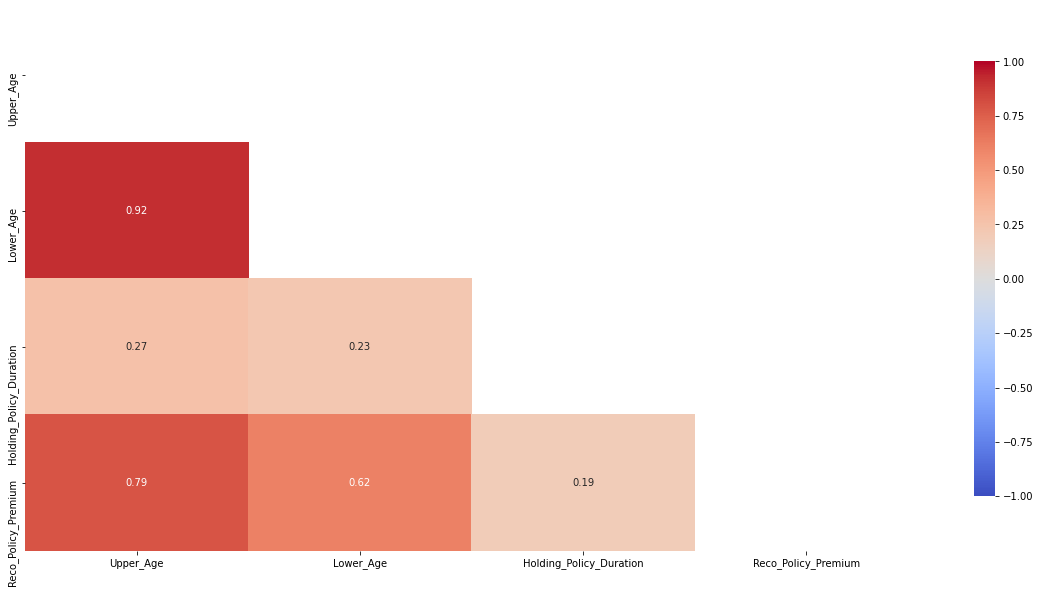

In [5]:
def get_correlation_heatmap(df):

    df_corr = df.corr()
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
               vmin=-1, vmax=1, cbar_kws={"shrink": .8})

get_correlation_heatmap(train)

In [6]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Upper_Age,50882.0,44.856275,17.310271,18.0,28.0,44.0,59.0,75.0
Lower_Age,50882.0,42.738866,17.319375,16.0,27.0,40.0,57.0,75.0
Holding_Policy_Duration,30631.0,55.689922,125.627614,1.0,2.0,5.0,9.0,365.0
Reco_Policy_Premium,50882.0,14183.950069,6590.074873,2280.0,9248.0,13178.0,18096.0,43350.4


In [7]:
# Let's construct a function that shows the summary and density distribution of a numerical attribute:
def eda_summary(data, x):
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n'
          f'{x.capitalize()}(min) : {x_min}\n'
          f'Q1                    : {Q1}\n'
          f'Q2(Median)            : {Q2}\n'
          f'Q3                    : {Q3}\n'
          f'{x.capitalize()}(max) : {x_max}')

    fig = plt.figure(figsize=(16, 10))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('pastel')
    
    plt.subplot(221)
    ax1 = sns.distplot(data[x], color = 'r')
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223)
    ax2 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224)
    ax3 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()


# Let's take a closer look at the Boxplot, and calculate the measure of skewness and totalnumber of outlier values for various attributes through a function:
def get_box_plot(data, x = 'bmi'):
    def add_values(bp, ax):
        """ This actually adds the numbers to the various points of the boxplots"""
        for element in ['whiskers', 'medians', 'caps']:
            for line in bp[element]:
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    x_line_center = x_l + (x_r - x_l)/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax.text(x_line_center, y_line_center, # Position
                            '%.2f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='center', # Centered vertically with line 
                            fontsize=12, backgroundcolor="white")

    fig, axes = plt.subplots(1, figsize=(4, 8))

    red_diamond = dict(markerfacecolor='r', marker='D')

    bp_dict = data.boxplot(column = x, 
                             grid=True, 
                             figsize=(4, 8), 
                             ax=axes, 
                             vert = True, 
                             notch=False, 
                             widths = 0.7, 
                             showmeans = True, 
                             whis = 1.5,
                             flierprops = red_diamond,
                             boxprops= dict(linewidth=3.0, color='black'),
                             whiskerprops=dict(linewidth=3.0, color='black'),
                             return_type = 'dict')

    add_values(bp_dict, axes)

    plt.title(f'{x.capitalize()} Boxplot', fontsize=16)
    plt.ylabel(f'{x.capitalize()}', fontsize=14)
    plt.show()
    
    skew = data[x].skew()
    Q1 = data[x].quantile(0.25)
    Q3 = data[x].quantile(0.75)
    IQR = Q3 - Q1
    total_outlier_num = ((data[x] < (Q1 - 1.5 * IQR)) | (data[x] > (Q3 + 1.5 * IQR))).sum()
    print(f'Mean {x.capitalize()} = {data[x].mean()}')
    print(f'Median {x.capitalize()} = {data[x].median()}')
    print(f'Skewness of {x}: {skew}.')
    print(f'Total number of outliers in {x} distribution: {total_outlier_num}.')


5 Point Summary of Upper_age Attribute:
Upper_age(min) : 18
Q1                    : 28.0
Q2(Median)            : 44.0
Q3                    : 59.0
Upper_age(max) : 75


/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


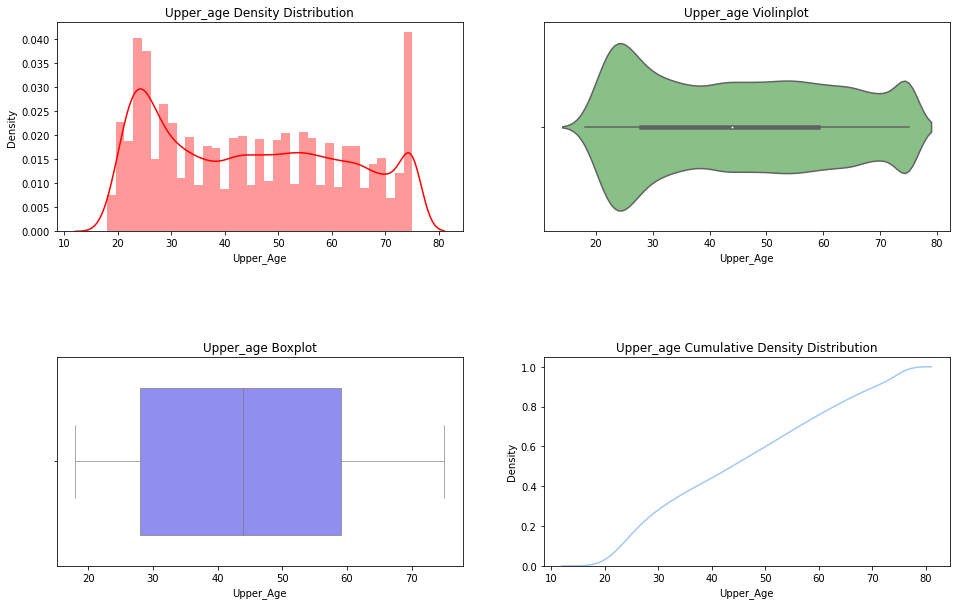

In [8]:
eda_summary(train, 'Upper_Age')

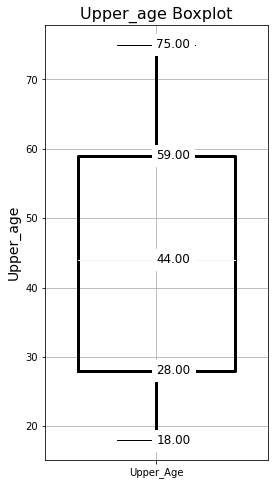

Mean Upper_age = 44.85627530364373
Median Upper_age = 44.0
Skewness of Upper_Age: 0.217370453151133.
Total number of outliers in Upper_Age distribution: 0.


In [9]:
get_box_plot(train, 'Upper_Age')

In [10]:
# train.loc[(train['Upper_Age']==train['Upper_Age'].max())].shape[0]
# train.loc[((train['Upper_Age']>=23) & (train['Upper_Age'] <=26))].shape[0]

5 Point Summary of Lower_age Attribute:
Lower_age(min) : 16
Q1                    : 27.0
Q2(Median)            : 40.0
Q3                    : 57.0
Lower_age(max) : 75


/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


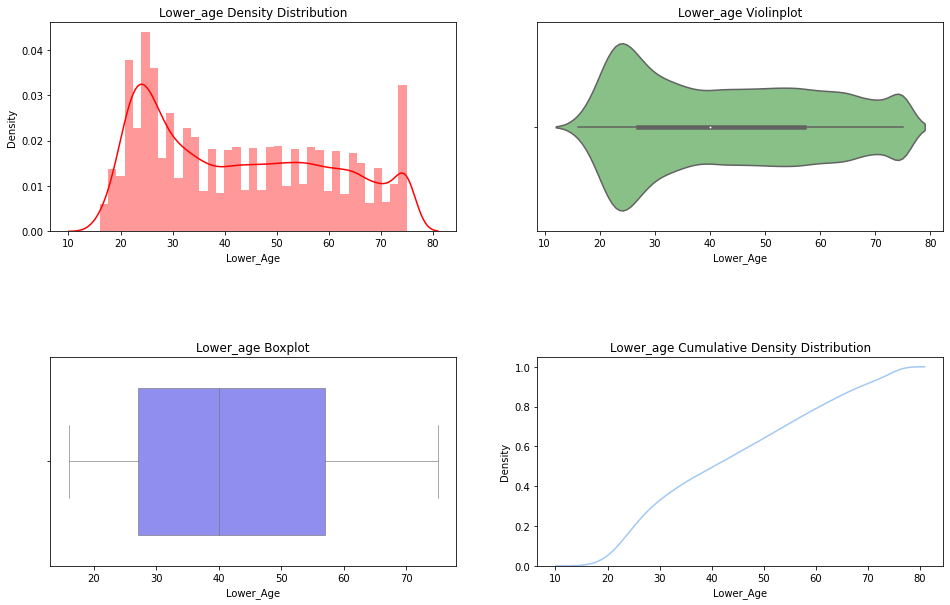

In [11]:
eda_summary(train, 'Lower_Age')

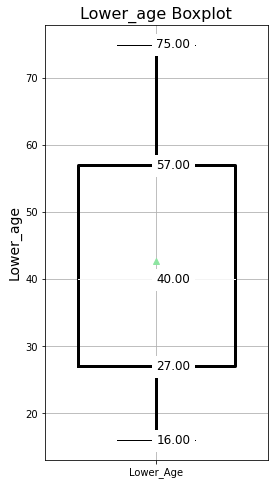

Mean Lower_age = 42.73886639676113
Median Lower_age = 40.0
Skewness of Lower_Age: 0.330594032216263.
Total number of outliers in Lower_Age distribution: 0.


In [12]:
get_box_plot(train, 'Lower_Age')

In [13]:
# train.loc[(train['Upper_Age']==train['Upper_Age'].max())].shape[0]
# train.loc[((train['Upper_Age']>=25) & (train['Upper_Age'] <=28))].shape[0]

5 Point Summary of Reco_policy_premium Attribute:
Reco_policy_premium(min) : 2280.0
Q1                    : 9248.0
Q2(Median)            : 13178.0
Q3                    : 18096.0
Reco_policy_premium(max) : 43350.4


/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


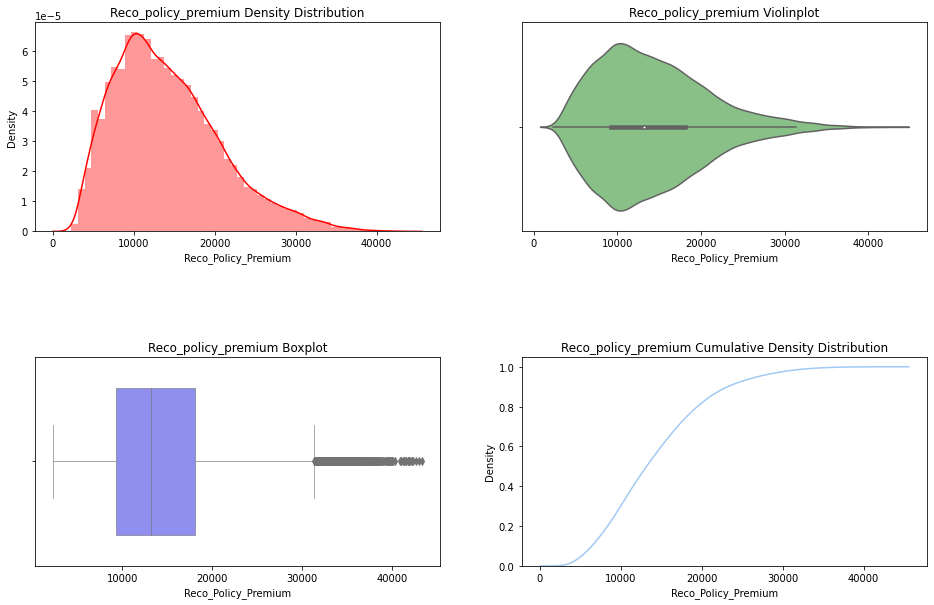

In [14]:
eda_summary(train, 'Reco_Policy_Premium')

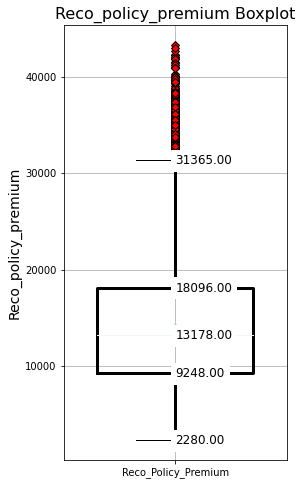

Mean Reco_policy_premium = 14183.950068786606
Median Reco_policy_premium = 13178.0
Skewness of Reco_Policy_Premium: 0.7824628894616024.
Total number of outliers in Reco_Policy_Premium distribution: 821.


In [15]:
get_box_plot(train, 'Reco_Policy_Premium')

5 Point Summary of Holding_policy_duration Attribute:
Holding_policy_duration(min) : 1.0
Q1                    : 2.0
Q2(Median)            : 5.0
Q3                    : 9.0
Holding_policy_duration(max) : 365.0


/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


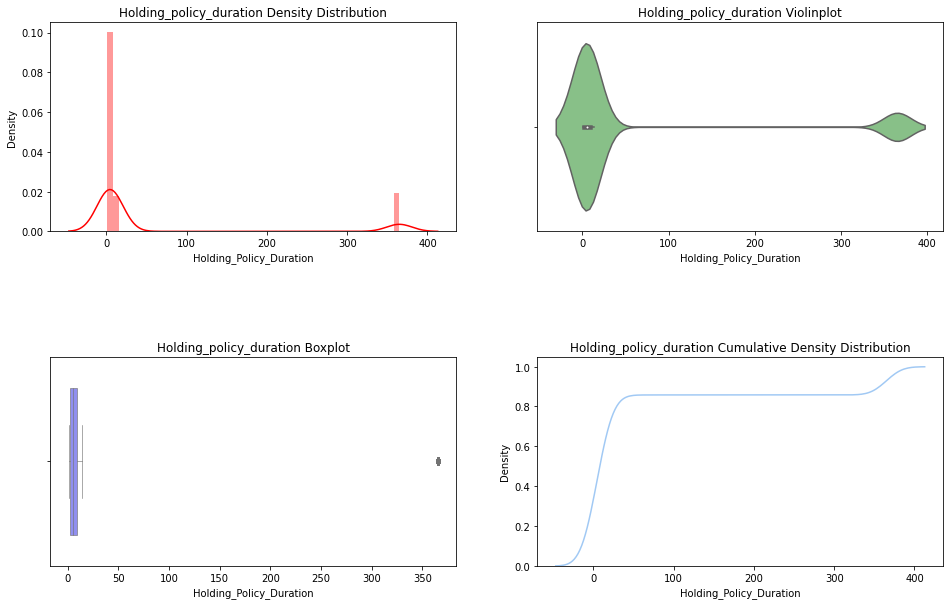

In [16]:
eda_summary(train, 'Holding_Policy_Duration')

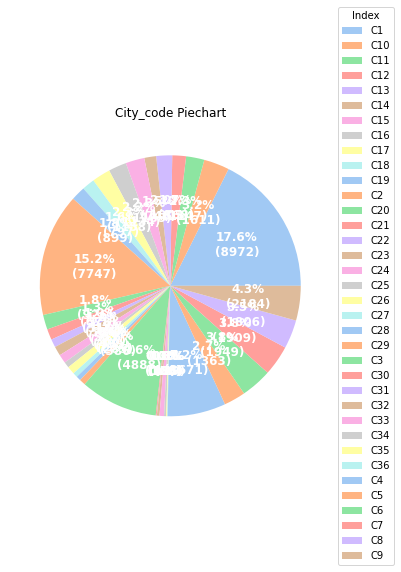

In [17]:
# Create a function that returns a Pie chart for categorical variable:
def get_pie_chart(data, x):
    """
    Function creates a Pie chart for categorical variables.
    """
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

    s = data.groupby(x).size()

    mydata_values = s.values.tolist()
    mydata_index = s.index.tolist()

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)


    wedges, texts, autotexts = ax.pie(mydata_values, autopct=lambda pct: func(pct, mydata_values),
                                      textprops=dict(color="w"))

    ax.legend(wedges, mydata_index,
              title="Index",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")

    ax.set_title(f'{x.capitalize()} Piechart')

    plt.show()



get_pie_chart(train, 'City_Code')

In [18]:
# get_pie_chart(train, 'Region_Code')

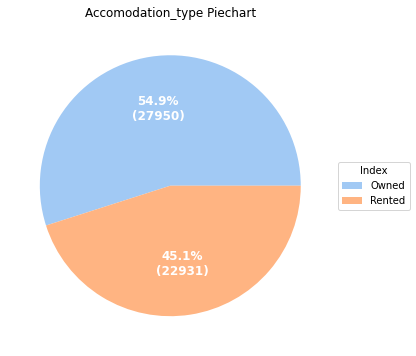

In [19]:
get_pie_chart(train, 'Accomodation_Type')

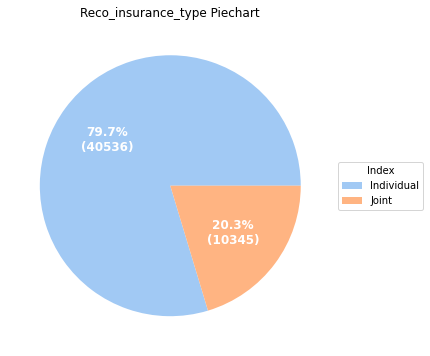

In [20]:
get_pie_chart(train, 'Reco_Insurance_Type')

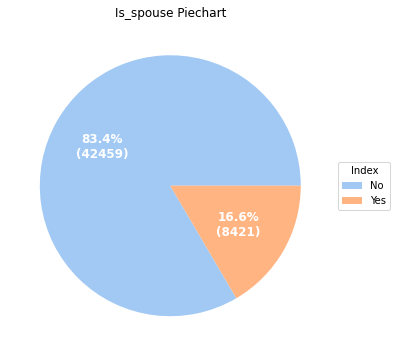

In [21]:
get_pie_chart(train, 'Is_Spouse')

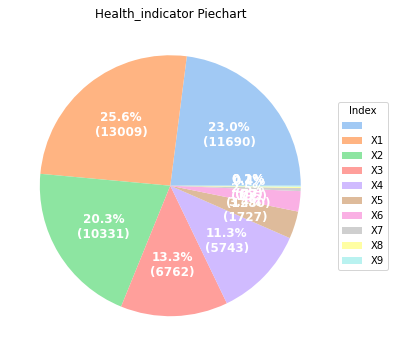

In [22]:
get_pie_chart(train, 'Health_Indicator')

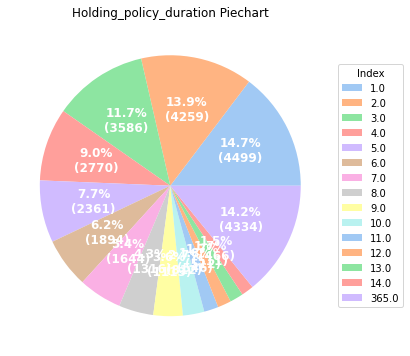

In [23]:
get_pie_chart(train, 'Holding_Policy_Duration')

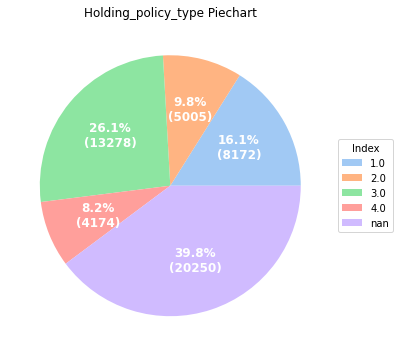

In [24]:
get_pie_chart(train, 'Holding_Policy_Type')

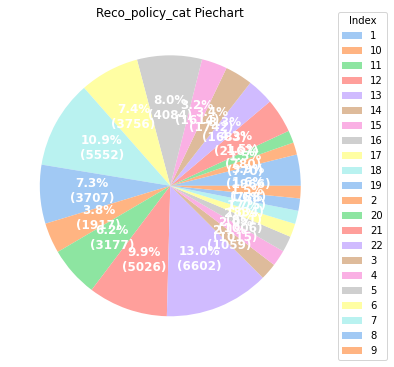

In [25]:
get_pie_chart(train, 'Reco_Policy_Cat')

<AxesSubplot:xlabel='Response', ylabel='count'>

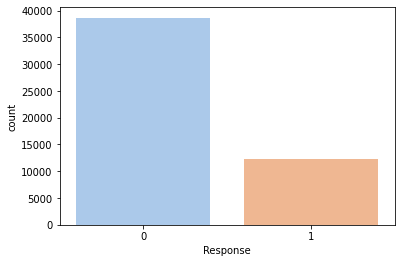

In [26]:
sns.countplot(x='Response', data=train)

<AxesSubplot:xlabel='Response', ylabel='count'>

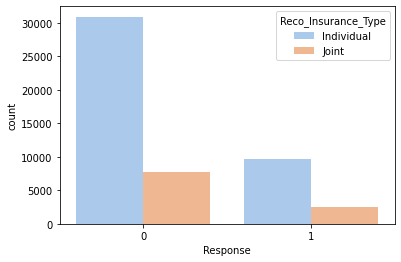

In [27]:
sns.countplot(x='Response', data=train, hue='Reco_Insurance_Type')

<AxesSubplot:xlabel='Response', ylabel='count'>

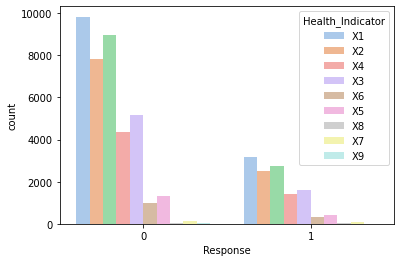

In [28]:
sns.countplot(x='Response', data=train, hue='Health_Indicator')

<AxesSubplot:xlabel='Response', ylabel='count'>

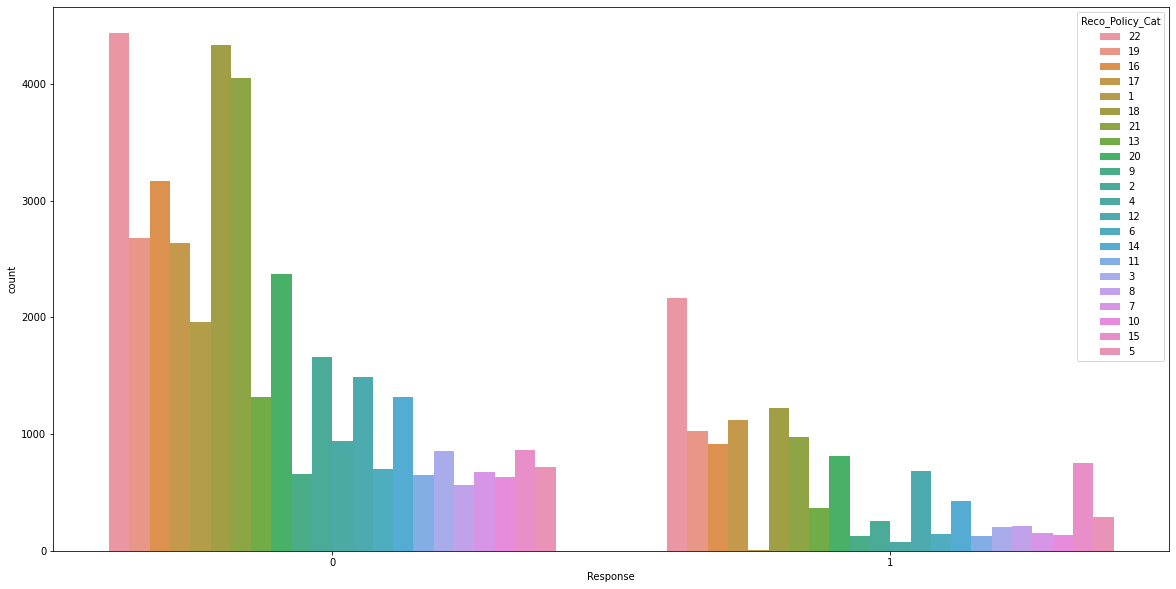

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(x='Response', data=train, hue='Reco_Policy_Cat')

<AxesSubplot:xlabel='Response', ylabel='count'>

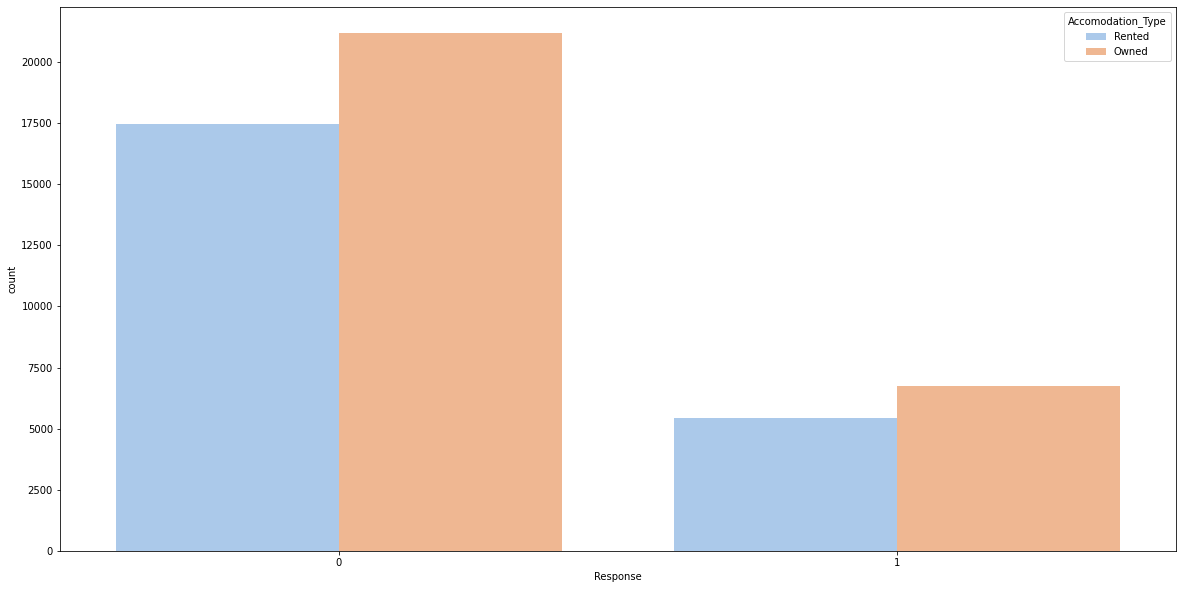

In [30]:
plt.figure(figsize=(20,10))
sns.countplot(x='Response', data=train, hue='Accomodation_Type')

<AxesSubplot:xlabel='Response', ylabel='count'>

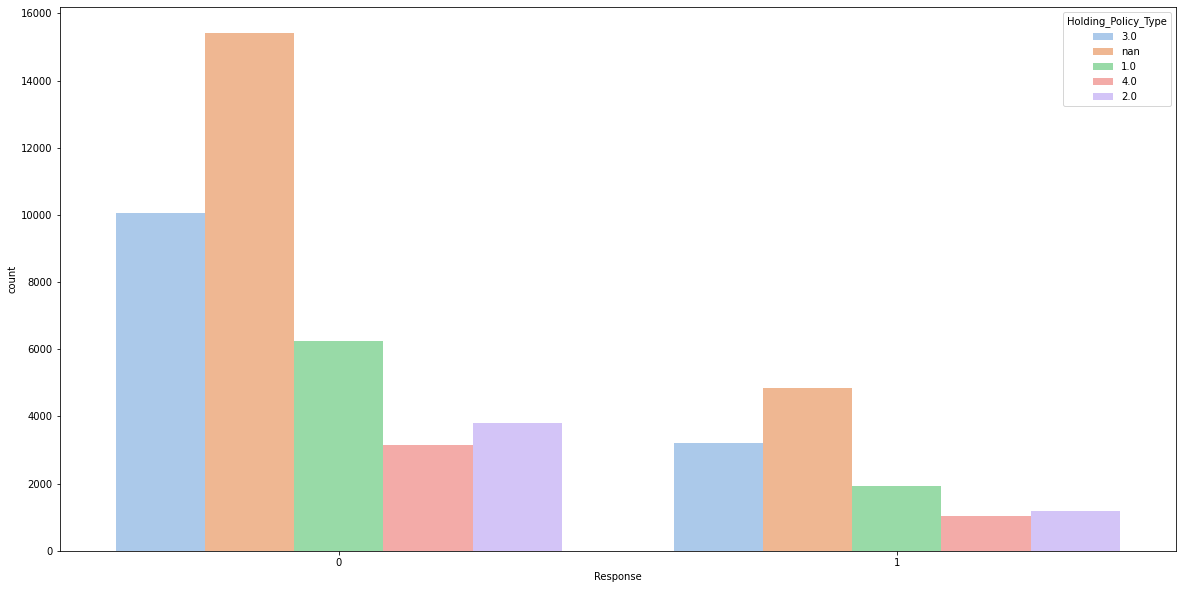

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(x='Response', data=train, hue='Holding_Policy_Type')

In [32]:
train.groupby(['Reco_Insurance_Type'])['Reco_Policy_Premium'].median()

Reco_Insurance_Type
Individual    11693.0
Joint         22080.0
Name: Reco_Policy_Premium, dtype: float64

In [33]:
train

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,365.0,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,nan,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,365.0,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,C4,845,Rented,Individual,22,22,No,X3,NaN,nan,18,7704.0,0
50878,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50879,C1,442,Rented,Individual,63,63,No,X2,365.0,1.0,12,11374.0,0
50880,C1,4,Owned,Joint,71,49,No,X2,2.0,2.0,16,28179.2,1


In [34]:

def get_label_encoded(train, test, col):
    
    le = LabelEncoder()
    le.fit(train[col])
    train[f'{col}_LE'] = le.transform(train[col])

    if col != 'Response':
        test[col] = test[col].map(lambda s: 'other' if s not in le.classes_ else s)
        le_classes = le.classes_.tolist()
        bisect.insort_left(le_classes, 'other')
        le.classes_ = le_classes
        test[f'{col}_LE'] = le.transform(test[col])
    
    # print(list(city_code_le.inverse_transform([1])))
    
    return train, test, le


categorical_columns = get_data_types_df(train).iloc[2,:].values
print(f'categorical_columns: {categorical_columns}')

train, test, city_code_le = get_label_encoded(train, test, 'City_Code')
train, test, region_code_le = get_label_encoded(train, test, 'Region_Code')
train, test, accomodation_type_le = get_label_encoded(train, test, 'Accomodation_Type')
train, test, reco_insurance_type_le = get_label_encoded(train, test, 'Reco_Insurance_Type')
train, test, is_spouse_le = get_label_encoded(train, test, 'Is_Spouse')
train, test, health_indicator_le = get_label_encoded(train, test, 'Health_Indicator')
train, test, holding_policy_type_le = get_label_encoded(train, test, 'Holding_Policy_Type')
train, test, reco_policy_cat_le = get_label_encoded(train, test, 'Reco_Policy_Cat')
train, test, response_le = get_label_encoded(train, test, 'Response')

train.sample(3)


categorical_columns: ['City_Code' 'Region_Code' 'Accomodation_Type' 'Reco_Insurance_Type'
 'Is_Spouse' 'Health_Indicator' 'Holding_Policy_Type' 'Reco_Policy_Cat'
 'Response']


,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,...,Response,City_Code_LE,Region_Code_LE,Accomodation_Type_LE,Reco_Insurance_Type_LE,Is_Spouse_LE,Health_Indicator_LE,Holding_Policy_Type_LE,Reco_Policy_Cat_LE,Response_LE
48124,C6,167,Owned,Individual,66,66,No,,1.0,3.0,...,0,32,651,0,0,0,0,2,6,0
20766,C16,593,Owned,Individual,53,53,No,X1,3.0,2.0,...,0,7,4766,0,0,0,1,1,12,0
26872,C4,2431,Rented,Individual,21,21,No,X1,NaN,nan,...,0,30,1378,1,0,0,1,4,10,0


In [35]:
pd.set_option('max_columns', None)

In [36]:
numerical_features = ['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration', 'Reco_Policy_Premium']
categorical_features = ['City_Code_LE', 'Region_Code_LE', 'Accomodation_Type_LE',
            'Reco_Insurance_Type_LE', 'Is_Spouse_LE', 'Health_Indicator_LE', 'Holding_Policy_Type_LE',
            'Reco_Policy_Cat_LE']
features = numerical_features + categorical_features
target = ['Response_LE']

df = train.reindex(features + target, axis=1)
df.sample(3)

,Upper_Age,Lower_Age,Holding_Policy_Duration,Reco_Policy_Premium,City_Code_LE,Region_Code_LE,Accomodation_Type_LE,Reco_Insurance_Type_LE,Is_Spouse_LE,Health_Indicator_LE,Holding_Policy_Type_LE,Reco_Policy_Cat_LE,Response_LE
31874,23,23,3.0,8112.0,22,4592,1,0,0,1,2,21,0
13522,51,48,11.0,23088.0,30,205,0,1,1,2,2,9,0
34169,50,50,6.0,11500.0,33,1806,1,0,0,5,2,5,0


In [37]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Light GBM

In [38]:
train_data = lgb.Dataset(X_train, label=y_train, feature_name=features, categorical_feature=categorical_features, free_raw_data=False)
valid_data = lgb.Dataset(X_test, label=y_test, feature_name=features, categorical_feature=categorical_features, free_raw_data=False)

param = {
    'cat_features' : categorical_features,
    'metric': 'auc',
    'seed': 42,
    'n_estimators': 10000
}

bst = lgb.LGBMClassifier(**param)
bst.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=-1)


# After training, the model can be saved:
# bst.save_model('model.txt')

# The trained model can also be dumped to JSON format:
# json_model = bst.dump_model()

# A saved model can be loaded:
# bst = lgb.Booster(model_file='model.txt')  # init model

# lgb.cv(param, train_data, num_round, nfold=5)

/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Unknown parameter: cat_features
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.662919


LGBMClassifier(cat_features=['City_Code_LE', 'Region_Code_LE',
                             'Accomodation_Type_LE', 'Reco_Insurance_Type_LE',
                             'Is_Spouse_LE', 'Health_Indicator_LE',
                             'Holding_Policy_Type_LE', 'Reco_Policy_Cat_LE'],
               metric='auc', n_estimators=10000, seed=42)

In [39]:
ypred_lgb = bst.predict_proba(X_test)[:,1]
roc_auc_score(y_test, ypred_lgb)


0.6629187771948198

/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Response', ylabel='Density'>

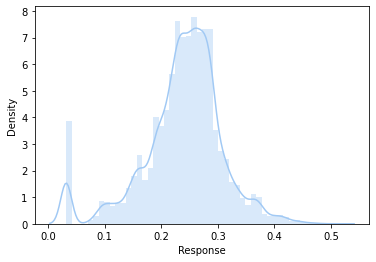

In [40]:
ytest = bst.predict_proba(test.reindex(features, axis=1))[:,1]
test['Response'] = ytest
test[['ID', 'Response']].to_csv('../data/lgbm_submission.csv', index=False)

sns.distplot(test.Response)



# XGBoost

In [41]:

dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist)

# bst.save_model('0001.model')

# dump model
# bst.dump_model('dump.raw.txt')
# dump model with feature map
# bst.dump_model('dump.raw.txt', 'featmap.txt')


# A saved model can be loaded as follows:
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('model.bin')  # load data


[0]	eval-auc:0.54581	train-auc:0.54289
[1]	eval-auc:0.56981	train-auc:0.56304
[2]	eval-auc:0.59870	train-auc:0.59252
[3]	eval-auc:0.60434	train-auc:0.59723
[4]	eval-auc:0.60700	train-auc:0.60413
[5]	eval-auc:0.60900	train-auc:0.60871
[6]	eval-auc:0.61194	train-auc:0.61003
[7]	eval-auc:0.62043	train-auc:0.61981
[8]	eval-auc:0.61960	train-auc:0.62275
[9]	eval-auc:0.62209	train-auc:0.62511
[10]	eval-auc:0.62171	train-auc:0.62670
[11]	eval-auc:0.62255	train-auc:0.62921
[12]	eval-auc:0.62331	train-auc:0.63101
[13]	eval-auc:0.62660	train-auc:0.63597
[14]	eval-auc:0.62596	train-auc:0.63760
[15]	eval-auc:0.62473	train-auc:0.63831
[16]	eval-auc:0.62662	train-auc:0.63963
[17]	eval-auc:0.62649	train-auc:0.63981
[18]	eval-auc:0.62524	train-auc:0.64077
[19]	eval-auc:0.62436	train-auc:0.64130
[20]	eval-auc:0.62364	train-auc:0.64256
[21]	eval-auc:0.62436	train-auc:0.64322
[22]	eval-auc:0.62510	train-auc:0.64444
[23]	eval-auc:0.62377	train-auc:0.64509
[24]	eval-auc:0.62483	train-auc:0.64640
[25]	eval-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

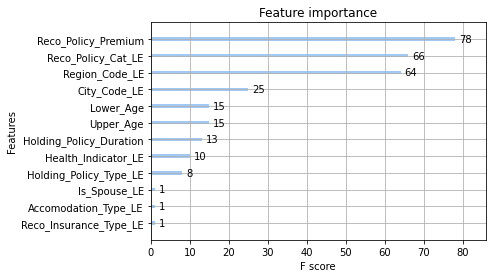

In [42]:
xgb.plot_importance(bst)

<AxesSubplot:>

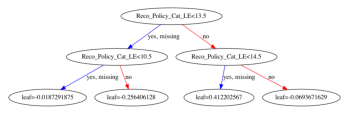

In [43]:
xgb.plot_tree(bst, num_trees=2)

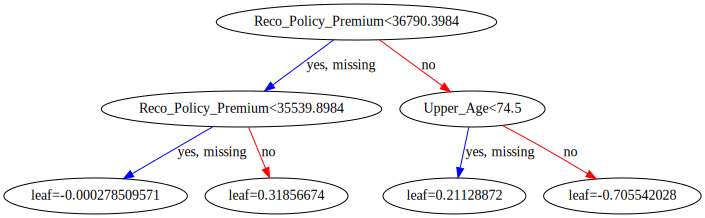

In [44]:
xgb.to_graphviz(bst, num_trees=99)

# Random Forest

In [45]:

clf = RandomForestClassifier()
clf = clf.fit(X_train.fillna(-999), y_train)

max(list(clf.predict(X_test.reindex(features, axis=1).fillna(-999))))


/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


1

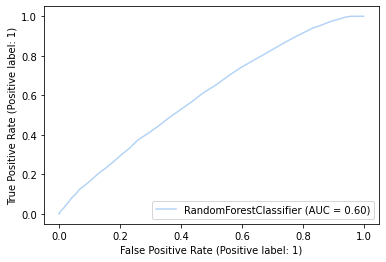

In [46]:

plot_roc_curve(clf, X_test.reindex(features, axis=1).fillna(-999),
                 y_test.reindex(target, axis=1).fillna(-999), alpha=0.8)
plt.show()


In [47]:
test

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,City_Code_LE,Region_Code_LE,Accomodation_Type_LE,Reco_Insurance_Type_LE,Is_Spouse_LE,Health_Indicator_LE,Holding_Policy_Type_LE,Reco_Policy_Cat_LE,Response
0,50883,C1,156,Owned,Individual,30,30,No,,6.0,3.0,5,11934.0,0,545,0,0,0,0,2,17,0.311051
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8,30,5031,0,1,1,1,2,9,0.246798
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0,0,4560,1,0,0,3,3,8,0.295648
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0,22,176,1,0,0,3,2,9,0.245358
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,nan,5,22534.0,0,5269,0,0,0,3,4,17,0.184624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,72683,C3,1044,Owned,Individual,45,45,No,X1,4.0,1.0,18,15884.0,22,44,0,0,0,1,0,9,0.194931
21801,72684,C4,266,Owned,Individual,59,59,No,X5,6.0,3.0,18,21390.0,30,1603,0,0,0,5,2,9,0.265445
21802,72685,C12,2470,Owned,Individual,74,74,No,X3,NaN,nan,1,17836.0,3,1415,0,0,0,3,4,0,0.031951
21803,72686,C10,1676,Rented,Individual,25,25,No,X4,3.0,1.0,19,11568.0,1,658,1,0,0,4,0,10,0.256275


In [48]:
test['Response'] = clf.predict(test.reindex(features, axis=1).fillna(-999))

test[['ID', 'Response']].to_csv('../data/submission_1.csv', index=False)

In [49]:
test[['ID', 'Response']].shape

(21805, 2)

# CatBoost

In [50]:


params = {
    'cat_features': categorical_features,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'n_estimators': 10000,
}

# Initialize CatBoostClassifier
model = CatBoostClassifier(**params, early_stopping_rounds=300)
# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, plot=True, verbose=False)
# Get predicted classes
preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:

print(f'roc_auc_score: {roc_auc_score(y_test, preds_class)}')
print(f'roc_auc_score: {roc_curve(y_test, preds_class)}')
precision, recall, thresholds = precision_recall_curve(y_test, preds_class)
print(f'precision: {precision}, recall: {recall}, thresholds: {thresholds}')
print(f'confusion_matrix: {confusion_matrix(y_test, preds_class)}')

roc_auc_score: 0.6162945123601612
roc_auc_score: (array([0.        , 0.06919625, 1.        ]), array([0.        , 0.30178528, 1.        ]), array([2, 1, 0]))
precision: [0.24350881 0.58400379 1.        ], recall: [1.         0.30178528 0.        ], thresholds: [0 1]
confusion_matrix: [[11824   879]
 [ 2855  1234]]


In [52]:
ypred_cat = model.predict_proba(X_test)[:,1]
print(ypred_cat)
roc_auc_score(y_test, ypred_cat)


[0.20284866 0.40510851 0.05469599 ... 0.08619301 0.01257336 0.40531844]


0.7983148580238631

<AxesSubplot:xlabel='importance'>

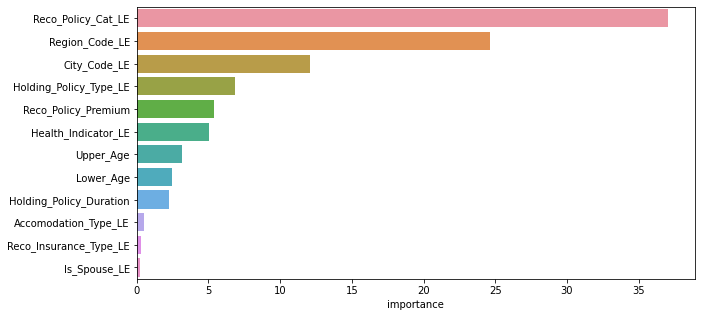

In [53]:
f_importance_df = pd.DataFrame(model.get_feature_importance(), columns=['importance'], index=X_test.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500])

/Users/saurabh/Personal/job_a_thon_av/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

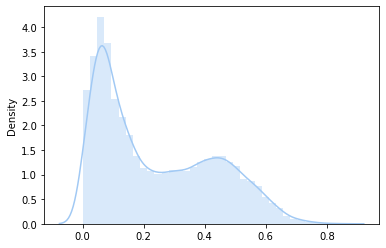

In [54]:
ypred_test = model.predict_proba(test.reindex(features, axis=1))[:,1]
sns.distplot(ypred_test)


In [55]:
test['Response'] = ypred_test

test[['ID', 'Response']].to_csv("../data/catboost_submission", index=False)


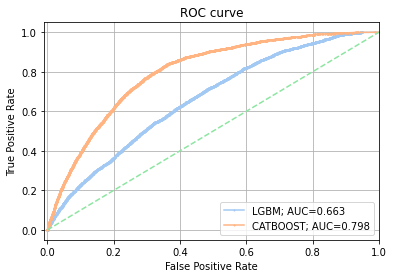

In [56]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

    
plot_roc(
    [y_test]*2,
    [ypred_lgb, ypred_cat],
    ['LGBM', 'CATBOOST']
)